# **1. Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# **2. Load dataset**

In [2]:
df = pd.read_csv('StudentsPerformance.csv')

In [3]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# **3. Basic Exploration**

In [4]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None
       math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000

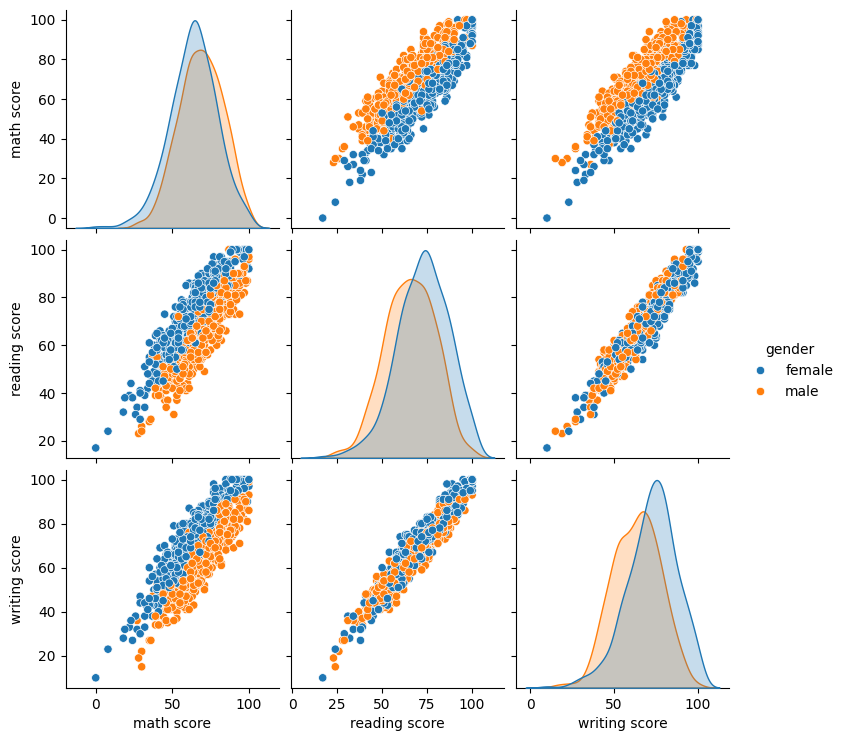

In [5]:
# Visualize distributions
sns.pairplot(df, vars=['math score','reading score','writing score'], hue="gender")
plt.show()

# **4. Features & Target**

In [6]:
X = df.drop(columns=["math score","reading score","writing score"])
y_math = df["math score"]
y_read = df["reading score"]
y_write = df["writing score"]

# **5. Encoding**

In [7]:
# Binary features -> LabelEncoder
# Multiclass -> OneHotEncoder
binary_cols = ["gender", "test preparation course"]
multi_cols = ["race/ethnicity", "parental level of education", "lunch"]

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("bin", OneHotEncoder(drop="first"), multi_cols),
        ("cat", LabelEncoder(), [])  # we'll handle LabelEncoder manually
    ],
    remainder="passthrough"
)

In [9]:
# Since LabelEncoder doesn't fit inside ColumnTransformer, handle manually:
df["gender"] = LabelEncoder().fit_transform(df["gender"])
df["test preparation course"] = LabelEncoder().fit_transform(df["test preparation course"])

In [10]:
# Update X after encoding binary
X = df.drop(columns=["math score","reading score","writing score"])

In [11]:
# OneHotEncode multiclass
X = pd.get_dummies(X, columns=multi_cols, drop_first=True)

In [12]:
print("Final Features:", X.columns)

Final Features: Index(['gender', 'test preparation course', 'race/ethnicity_group B',
       'race/ethnicity_group C', 'race/ethnicity_group D',
       'race/ethnicity_group E',
       'parental level of education_bachelor's degree',
       'parental level of education_high school',
       'parental level of education_master's degree',
       'parental level of education_some college',
       'parental level of education_some high school', 'lunch_standard'],
      dtype='object')


# **6. Train/Test Split**

In [13]:
X_train, X_test, y_math_train, y_math_test = train_test_split(X, y_math, test_size=0.2, random_state=42)
_, _, y_read_train, y_read_test = train_test_split(X, y_read, test_size=0.2, random_state=42)
_, _, y_write_train, y_write_test = train_test_split(X, y_write, test_size=0.2, random_state=42)

In [14]:
def evaluate_model(model, X_train, X_test, y_train, y_test, target_name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    print(f"---- {target_name} ----")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print()
    return preds

# **8. Try Different Models**

In [15]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

In [16]:
for name, model in models.items():
    print(f"=== Model: {name} ===")
    evaluate_model(model, X_train, X_test, y_math_train, y_math_test, "Math Score")
    evaluate_model(model, X_train, X_test, y_read_train, y_read_test, "Reading Score")
    evaluate_model(model, X_train, X_test, y_write_train, y_write_test, "Writing Score")

=== Model: LinearRegression ===
---- Math Score ----
MAE: 11.269872775277623
RMSE: 14.160185226319358

---- Reading Score ----
MAE: 10.830287958543586
RMSE: 13.79186391872779

---- Writing Score ----
MAE: 10.193142948785425
RMSE: 13.32111674103065

=== Model: RandomForest ===
---- Math Score ----
MAE: 12.39494591451075
RMSE: 15.730109625318919

---- Reading Score ----
MAE: 11.86399430317474
RMSE: 15.182278766914626

---- Writing Score ----
MAE: 11.183232637440184
RMSE: 14.667682405698

=== Model: GradientBoosting ===
---- Math Score ----
MAE: 11.60996256129959
RMSE: 14.761904126136127

---- Reading Score ----
MAE: 11.2204812978966
RMSE: 14.33090138240176

---- Writing Score ----
MAE: 10.5959814384318
RMSE: 13.921744406715739



# **9. Feature Importance (RandomForest Example)**

In [17]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_math_train)
importances = rf.feature_importances_

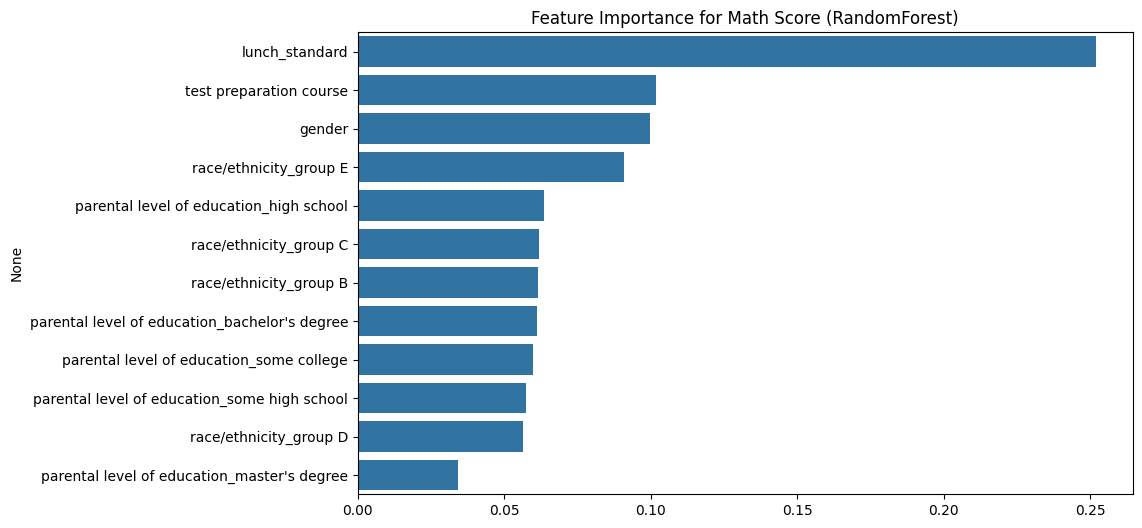

In [18]:
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance for Math Score (RandomForest)")
plt.show()

# **10. Collect Results for Visualization**

In [19]:
results = []

for name, model in models.items():
    for target_name, (y_train, y_test) in zip(
        ["Math", "Reading", "Writing"],
        [(y_math_train, y_math_test), (y_read_train, y_read_test), (y_write_train, y_write_test)]
    ):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        results.append({"Model": name, "Target": target_name, "MAE": mae, "RMSE": rmse})

results_df = pd.DataFrame(results)
print(results_df)

              Model   Target        MAE       RMSE
0  LinearRegression     Math  11.269873  14.160185
1  LinearRegression  Reading  10.830288  13.791864
2  LinearRegression  Writing  10.193143  13.321117
3      RandomForest     Math  12.394946  15.730110
4      RandomForest  Reading  11.863994  15.182279
5      RandomForest  Writing  11.183233  14.667682
6  GradientBoosting     Math  11.609963  14.761904
7  GradientBoosting  Reading  11.220481  14.330901
8  GradientBoosting  Writing  10.595981  13.921744


# **11. Visualization**

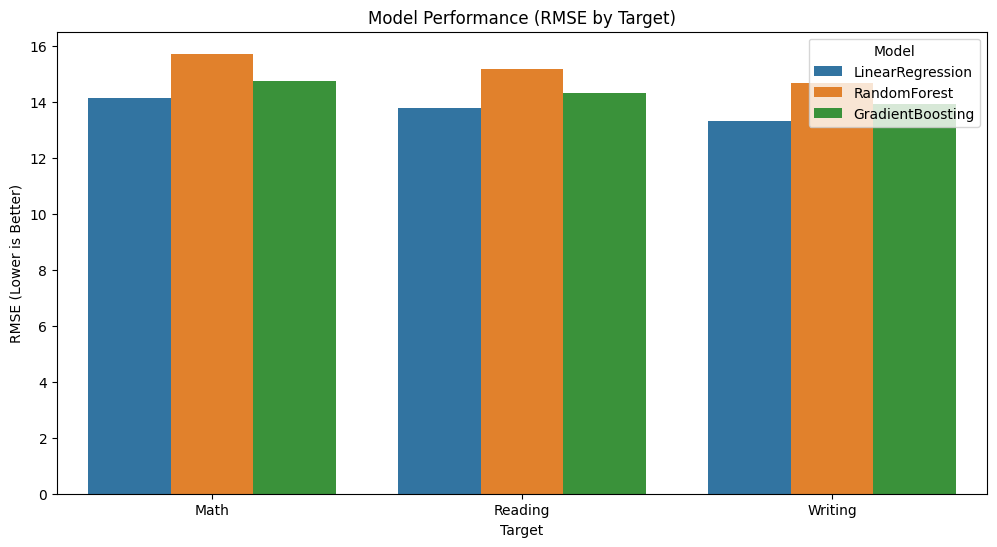

In [20]:
plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x="Target", y="RMSE", hue="Model")
plt.title("Model Performance (RMSE by Target)")
plt.ylabel("RMSE (Lower is Better)")
plt.show()

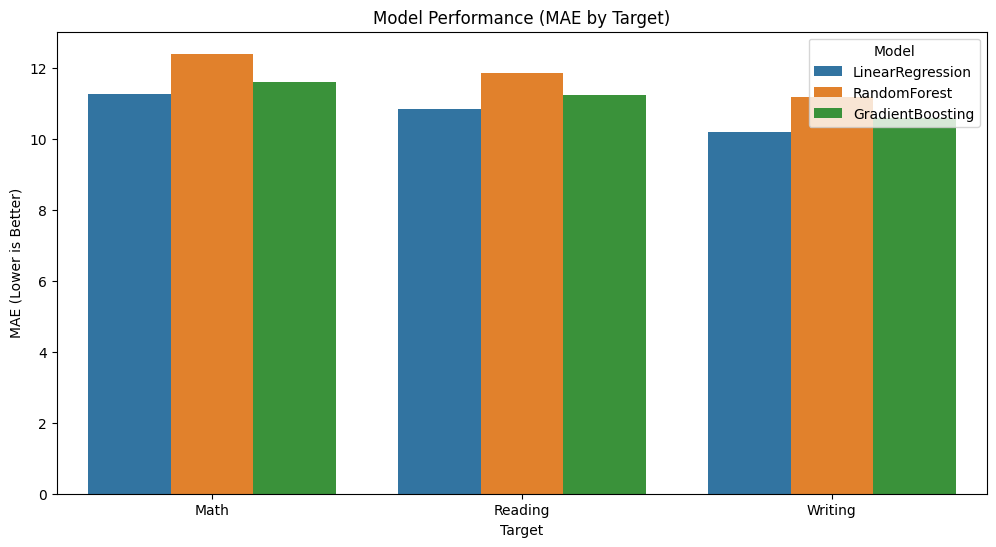

In [21]:
plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x="Target", y="MAE", hue="Model")
plt.title("Model Performance (MAE by Target)")
plt.ylabel("MAE (Lower is Better)")
plt.show()